# Project Information

It's always interesting to see how new leagues start in Path of Exile. As with most leagues, mines or traps are usually the most played builds at the start of the league. So, I've taken this opportunity to see how this new league fares in terms of builds at league start.

NOTE: I haven't actively played PoE since Harvest League (June 2020 until September 2020), I dabbled a bit in Heist but didn't really get into it much. So my knowledge on current PoE is very outdated.

# Background Information

With the new Affliction league in PoE being released, it will be interesting to see what the current meta is by looking at (scraping) the top dps builds at the moment. To do that, we can browse [poe.ninja](https://poe.ninja/builds/affliction?sort=dps) sorted by DPS to see how much DPS each build is doing. Furthermore, since this web scraping is done at a specific time, the data will most likely not fully represent current data. A script will be provided that will scrape data and save it as csv with appropriate time markings.

The `robots.txt` 
```
user-agent: *
disallow: */builds/char/*

sitemap: https://poe.ninja/sitemap.xml
```
disallows crawlers from accessing each individual character. This project will respect the exclusion protocol and only browse the endpoint `/builds/affliction` and not go into each character's page.

# Libraries

In [74]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
from time import sleep
from datetime import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup

In [2]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

The elements that will be scraped are as follows:
1. Level
2. Ascendancy
3. DPS
4. Skill(s)
5. Keystones
6. Life
7. Energy Shield

In [3]:
class Build:
    """
    The class `Build` will be an object that takes in the elements mentioned above. The Class will be mapped from
    the given ascendancy since the website does not directly provide the class, only the ascendancy.
    """
    class_asc = { # Class Ascendancies Mapping
        'Ranger': ['Deadeye', 'Pathfinder', 'Raider'],
        'Duelist': ['Slayer', 'Gladiator', 'Champion'],
        'Shadow': ['Assassin', 'Trickster', 'Saboteur'],
        'Marauder': ['Chieftain', 'Berserker', 'Juggernaut'],
        'Witch': ['Elementalist', 'Occultist', 'Necromancer'],
        'Templar': ['Inquisitor', 'Hierophant', 'Guardian'],
        'Scion': ['Ascendant']    
    }
    
    # Inverse mapping for each ascendancies in class_asc to fetch the class
    class_asc_inverse = {asc: cls_ for cls_, ascs in class_asc.items() for asc in ascs}
    
    def __init__(self, level: int, asc: str, dps: str, skill: str, keystone: str, life: int, es: int):
        self.level = level # Level
        self.cls = self.class_asc_inverse.get(asc, 'Not found') # Class
        self.asc = asc # Ascendancy
        self.dps = dps # Damage per Second
        self.skill = skill # Skill(s), encase in [] when using multiple skills
        self.keystone = keystone # Keystone(s), encase in [] when you have multiple keystones
        self.life = life # HP
        self.es = es # Energy shield
        
    def __str__(self):
        return f'Level {self.level} {self.cls} - {self.asc} \n\
    Skill: {self.skill},\n\
    Keystones: {self.keystone}, \n\
    does {self.dps} damage per second.'

In [4]:
test_build = Build(95, 'Inquisitor', '250M', ['Flicker Strike', 'Molten Strike'], 'Hex Master', 3500, 0)
print(test_build)

Level 95 Templar - Inquisitor 
    Skill: ['Flicker Strike', 'Molten Strike'],
    Keystones: Hex Master, 
    does 250M damage per second.


# Web Scraping

## Request check

In [5]:
url = 'https://poe.ninja/builds/affliction?sort=dps'
response = requests.get(url)
response

<Response [200]>

## Fetching data

Sometimes when running the cell below, there might be occurrences where the table is empty. To combat that, we can implement a retry mechanism.

In [77]:
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('Web scraped at: ', current_time)
driver = webdriver.Chrome(options=chrome_options)

max_attempts = 5
attempts = 1
table = None

while attempts < max_attempts and table is None:
    print('Attempt #', attempts)
    driver.get(url)
    WebDriverWait(driver, 10).until( # Waits up to a maximum of 10s until the table appears
        EC.presence_of_element_located((By.CSS_SELECTOR, "table._builds-table_8h86n_1"))
    )
    html = driver.page_source
    soup = bs(html, 'html.parser')
    table = soup.body.find('table', class_= "_builds-table_8h86n_1")
    attempts += 1
    if table:
        print('Success')
        driver.quit()
        break
    sleep(3)
    
if not table:
    print('Failed to fetch table after 5 attempts.')
    driver.quit()

Web scraped at:  2023-12-12 23:07:52
Attempt # 1


In [79]:
tbody = table.find('tbody')
table_rows = tbody.find_all('tr')
len(table_rows)

100

In [10]:
def fetch_builds(table_rows=table_rows):
    """
    This function fetches all the elements we want to grab by parsing through each row
    and fetch the relevant table cells <td>.
    The parameters:
    1. table_rows -> All the table rows from the website
    """
    builds = [] # List to store all the build informations
    
    for row in table_rows:
        cells = row.find_all('td') # Fetch all cells from the row
        life = cells[2].getText() # Life
        es = cells[3].getText() # Energy shield
        dps = cells[4].getText() # DPS
        
        # Lvl / Asc
        level = cells[1].find('div', class_='grid gap-2 items-center grid-flow-col').getText() # Level
        asc = cells[1].find('img')['alt'] # Ascendancy
        
        # Skills
        all_skills = cells[5].find('div', class_='grid grid-flow-col auto-cols-max gap-1').find_all('img')
        skills = [skill_alt['alt'] for skill_alt in all_skills]
        
        # Keystones
        try:
            all_keystones = cells[5].find('div', class_='grid grid-flow-col auto-cols-max gap-1 justify-end').find_all('img')
            keystones = [keystone_alt['alt'] for keystone_alt in all_keystones]
        except AttributeError:
            keystones = []
            
        # print(level, asc, life, es, dps, skills, keystones)
        build = Build(level, asc, dps, skills, keystones, life, es)
        builds.append(build)
        
    return builds
builds = fetch_builds()

In [11]:
len(builds)

100

# Tabularise data

In [12]:
df = pd.DataFrame({
    'Level': [build.level for build in builds],
    'Class': [build.cls for build in builds],
    'Ascendancy': [build.asc for build in builds],
    'DPS': [build.dps for build in builds],
    'Skill': [build.skill for build in builds],
    'Keystone': [build.keystone for build in builds],
    'Life': [build.life for build in builds],
    'ES': [build.es for build in builds]
})
df.head(5)

,Level,Class,Ascendancy,DPS,Skill,Keystone,Life,ES
0,96,Witch,Occultist,290M,[Ice Trap skill],"[Pain Attunement, Eldritch Battery]",1735,477
1,94,Shadow,Assassin,236M,[Ice Trap skill],"[Hex Master, Pain Attunement, Eldritch Battery]",1459,437
2,94,Shadow,Saboteur,167M,[Ice Trap skill],"[Hex Master, Pain Attunement, Eldritch Battery]",1229,426
3,90,Witch,Occultist,149M,[Ice Trap skill],"[Hex Master, Pain Attunement, Eldritch Battery]",1229,427
4,90,Witch,Occultist,145M,[Ice Trap skill],"[Hex Master, Pain Attunement, Eldritch Battery]",1249,420


## Clean data

In [13]:
def clean_data(df=df):
    # Level to int
    df['Level'] = df['Level'].astype(int)
    
    # DPS
    # - Replace M with 000000
    # - Remove 'dot'
    # - Change to int
    df['DPS'] = df['DPS'].str.replace('M', '000000').str.replace('dot', '').astype(int)
    
    # Life & ES to int
    df['Life'] = df['Life'].astype(int)
    df['ES'] = df['ES'].astype(int)
    
    return df

In [14]:
df = clean_data(df)
df.sample(5)


,Level,Class,Ascendancy,DPS,Skill,Keystone,Life,ES
45,94,Templar,Hierophant,21000000,[Ice Spear skill],"[Ancestral Bond, Mind Over Matter, Minion Inst...",2338,641
64,93,Witch,Occultist,16000000,[Hexblast skill],"[Eldritch Battery, Ghost Dance]",3075,2024
85,91,Marauder,Berserker,14000000,"[Blade Flurry skill, General's Cry skill]","[Call to Arms, Unwavering Stance]",3558,0
41,93,Witch,Elementalist,22000000,[Lightning Conduit skill],[Eldritch Battery],3209,592
50,94,Witch,Occultist,19000000,[Discharge skill],"[Elemental Equilibrium, Pain Attunement]",2049,88


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Level       100 non-null    int64 
 1   Class       100 non-null    object
 2   Ascendancy  100 non-null    object
 3   DPS         100 non-null    int64 
 4   Skill       100 non-null    object
 5   Keystone    100 non-null    object
 6   Life        100 non-null    int64 
 7   ES          100 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 6.4+ KB


In [16]:
df.to_csv('poeninja.csv', index=False)

# Load data

In [17]:
df = pd.read_csv('poeninja.csv')
df.head()

,Level,Class,Ascendancy,DPS,Skill,Keystone,Life,ES
0,96,Witch,Occultist,290000000,['Ice Trap skill'],"['Pain Attunement', 'Eldritch Battery']",1735,477
1,94,Shadow,Assassin,236000000,['Ice Trap skill'],"['Hex Master', 'Pain Attunement', 'Eldritch Ba...",1459,437
2,94,Shadow,Saboteur,167000000,['Ice Trap skill'],"['Hex Master', 'Pain Attunement', 'Eldritch Ba...",1229,426
3,90,Witch,Occultist,149000000,['Ice Trap skill'],"['Hex Master', 'Pain Attunement', 'Eldritch Ba...",1229,427
4,90,Witch,Occultist,145000000,['Ice Trap skill'],"['Hex Master', 'Pain Attunement', 'Eldritch Ba...",1249,420


# Exploratory Data Analysis

NOTE: Since the league is still relatively new, expect to get different results everytime the scraping is done.

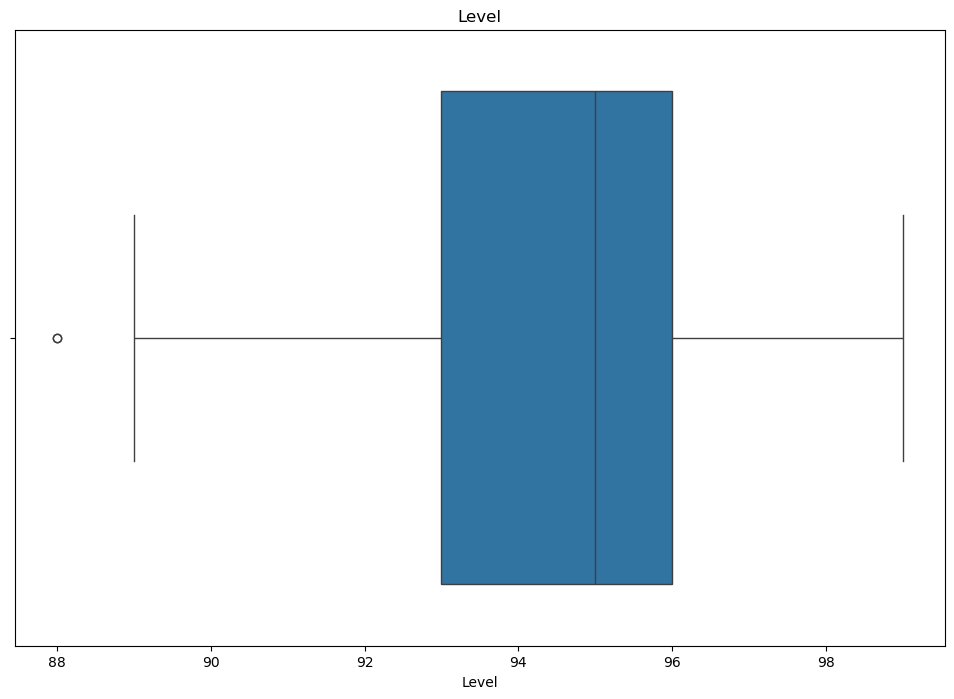

In [18]:
# Level
plt.figure(figsize=(12, 8))
sns.boxplot(x=df['Level'])
plt.title('Level')
plt.show()

In [19]:
df['Class'].value_counts()

Class
Witch       39
Templar     27
Shadow      17
Marauder    12
Ranger       4
Duelist      1
Name: count, dtype: int64

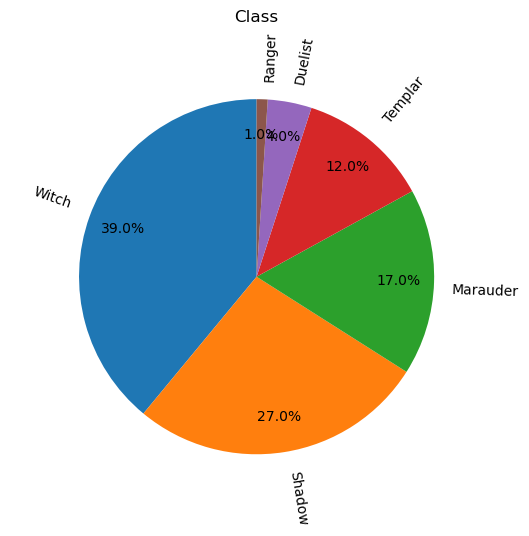

,Class
Class,
Witch,39
Templar,27
Shadow,17
Marauder,12
Ranger,4
Duelist,1


In [27]:
# Class
class_count = pd.DataFrame()
class_count['Class'] = df.Class.value_counts()

labels = df['Class'].unique()
plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.pie(class_count['Class'], autopct='%1.1f%%', labels=labels, pctdistance=0.8, startangle=90,rotatelabels=True, radius=0.9)
plt.title('Class')
plt.show()

display(class_count)

Witch is the most popular. There are 39 witches on the top 100 DPS charts. Let's look at the ascendancies.

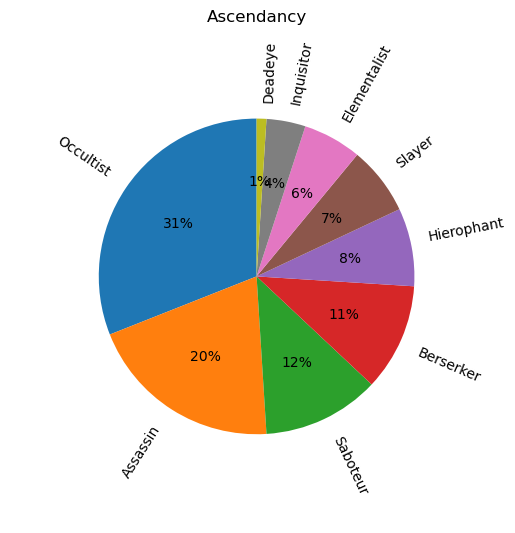

In [21]:
# Ascendancies
labels = df['Ascendancy'].unique()
plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.pie(df['Ascendancy'].value_counts(), labels=labels, autopct='%.0f%%', pctdistance=0.6, startangle=90, rotatelabels=True, radius=0.8)
plt.title('Ascendancy')
plt.show()

- The most played ascendancy is occultist at 31%, which means around 93% of witches are occultists, the remaining 7% are elementalists with no necromancers
- The second most played is Assassin (Shadow) at 20%
- The third most played is Saboteur at 12%, this is expected because mine builds is usually very famous at league start

Let's explore what top three ascendancies uses.

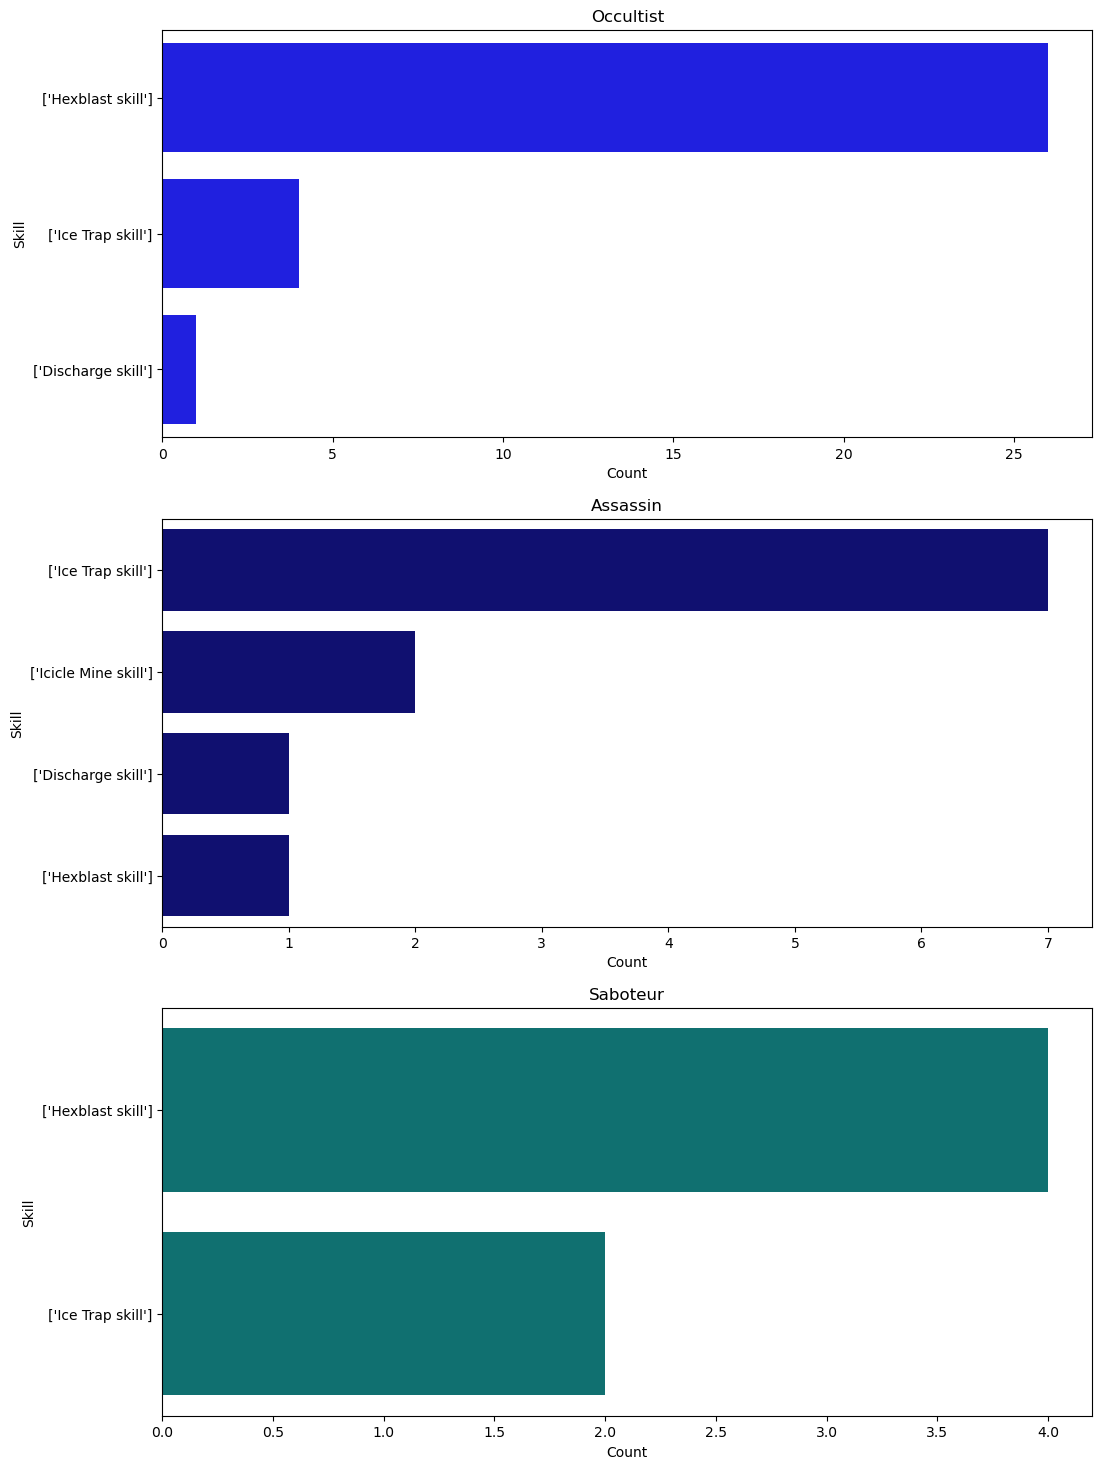

In [47]:
plt.figure(figsize=(12, 18))

occultist_df = df[df['Ascendancy'] == 'Occultist']
plt.subplot(3, 1, 1)
sns.countplot(data=occultist_df, y='Skill', color='blue', order=occultist_df['Skill'].value_counts().index)
plt.xlabel('Count')
plt.title('Occultist')

assassin_df = df[df['Ascendancy'] == 'Assassin']
plt.subplot(3, 1, 2)
sns.countplot(data=assassin_df, y='Skill', color='navy', order=assassin_df['Skill'].value_counts().index)
plt.xlabel('Count')
plt.title('Assassin')

saboteur_df = df[df['Ascendancy'] == 'Saboteur']
plt.subplot(3, 1, 3)
sns.countplot(data=saboteur_df, y='Skill', color='teal', order=saboteur_df['Skill'].value_counts().index)
plt.xlabel('Count')
plt.title('Saboteur')

plt.show()

- Hexblast:
Deals chaos damage to a single enemy, dealing more damage if they are Hexed, then removes the Hex with the highest Doom. If a Hex was removed this way, also deals area damage to other enemies around the target, boosting damage and removing Hexes from those enemies in the same way. [Source](https://pathofexile.fandom.com/wiki/Hexblast)

- Ice trap:
Throws a trap that creates a series of icy runic explosions when triggered, dealing cold damage to all enemies caught in the blasts. [Source](https://pathofexile.fandom.com/wiki/Ice_Trap)

- Hexblast and Ice trap is one of the most used skills for both the top three ascendancies, with the exception for Hexblast on Assassin
- Icicle mine is the second most used skill for Assassin

This further emphasizes Hexblast as the top skill for this league's start. Since this is the start of the league, hexblast on occultist can also be assumed as hexblast mine instead of selfcast. As with most league starts, mines and traps are usually the most played builds.

Now let's check how much damage they're able to dish out.

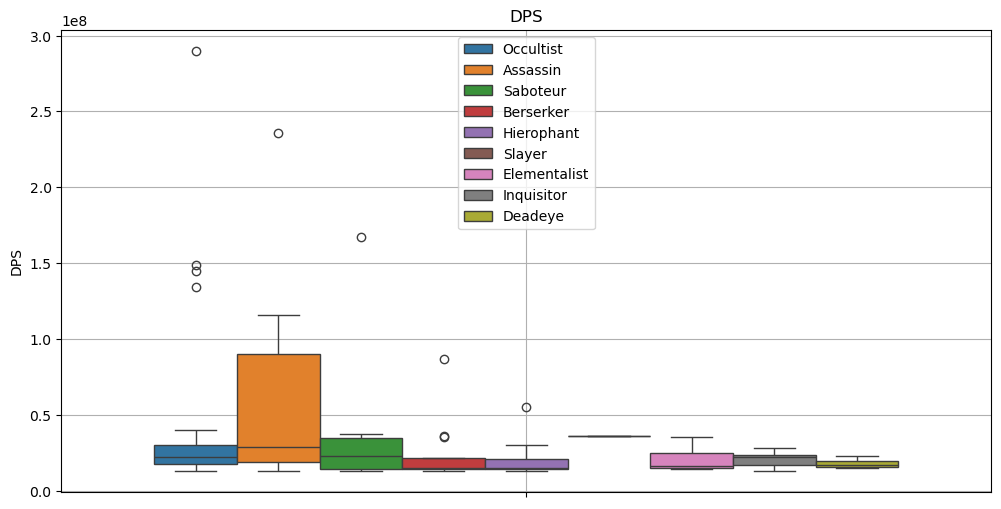

In [66]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y='DPS', hue='Ascendancy')
plt.legend(loc='upper center')
plt.grid()
plt.title('DPS')
plt.show()

- Occultist and Assassin has extreme outliers
- In terms of the top three ascendancies used (Occultist, Assassin, Saboteur), Occultist and Saboteur's damage is more uniform than Assassin
- Assassin's overall DPS is more spread out 

Let's check out the outliers from the top 3 ascendancies.

In [86]:
# Occultist outliers
occultist_df.query('DPS > 1e8')

,Level,Class,Ascendancy,DPS,Skill,Keystone,Life,ES
0,96,Witch,Occultist,290000000,['Ice Trap skill'],"['Pain Attunement', 'Eldritch Battery']",1735,477
3,90,Witch,Occultist,149000000,['Ice Trap skill'],"['Hex Master', 'Pain Attunement', 'Eldritch Ba...",1229,427
4,90,Witch,Occultist,145000000,['Ice Trap skill'],"['Hex Master', 'Pain Attunement', 'Eldritch Ba...",1249,420
5,94,Witch,Occultist,134000000,['Ice Trap skill'],"['The Agnostic', 'Pain Attunement', 'Eldritch ...",1228,415


All of the Occultist outliers use Ice Trap with similar keystones, for reference
- [Hex Master](https://www.poewiki.net/wiki/Hex_Master)
> Your Hexes have infinite Duration. 20% less Effect of your Curses
- [The Agnostic](https://www.poewiki.net/wiki/The_Agnostic)
> Maximum Energy Shield is 0. While not on Full Life, Sacrifice 20% of Mana per Second to Recover that much Life
- [Pain Attunement](https://www.poewiki.net/wiki/Pain_Attunement)
> 30% more Spell Damage when on Low Life

[Low life](https://www.poewiki.net/wiki/Low_life) is active when your life is 50% or lower.

Looking at the top two characters here, the biggest difference is the links on the weapon. 
- The top dps has a 6-link [The Annihilating Light](https://www.poewiki.net/wiki/The_Annihilating_Light), while the second one has a 5-link
- The top dps has more trap throwing speed than the second

In [91]:
# Assassin outliers
display(assassin_df.query('DPS > 1.5e8'))

# Saboteur outliers
display(saboteur_df.query('DPS > 1e8'))

,Level,Class,Ascendancy,DPS,Skill,Keystone,Life,ES
1,94,Shadow,Assassin,236000000,['Ice Trap skill'],"['Hex Master', 'Pain Attunement', 'Eldritch Ba...",1459,437


,Level,Class,Ascendancy,DPS,Skill,Keystone,Life,ES
2,94,Shadow,Saboteur,167000000,['Ice Trap skill'],"['Hex Master', 'Pain Attunement', 'Eldritch Ba...",1229,426


Similar to Occultist, the outliers on Assassin and Saboteur also use Ice Trap with similar keystones. Without checking their gear, we can also assume the gear being the biggest determining factor in damage, followed with ascendancy choice.

# Conclusion

As with most leagues, mines or traps are usually the most played builds at the start of the league due to its safety and possibly off-screen potential. There aren't any recommendations here because this is more of a personal interest project. Play whatever build you want! Re-roll or make a new character if it sucks.

# Flicker Strike best build